In [5]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from numpy import sqrt 

#Tien Xu Ly
from sklearn.preprocessing import MinMaxScaler

#Draw Flot
import matplotlib.pyplot as plt

#Cacuale error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#dtw Libaray
from dtw import dtw

#FFNN Libarary
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

In [6]:
# Load dữ liệu
dataCSV = pd.read_csv('D:/DATN/Dataset/HPQ.csv')
dataCSV

Date       Open       High        Low      Close  Adj Close  \
0      1962-01-02   0.131273   0.131273   0.124177   0.124177   0.006887   
1      1962-01-03   0.124177   0.124177   0.121516   0.122846   0.006813   
2      1962-01-04   0.122846   0.126838   0.117968   0.120185   0.006666   
3      1962-01-05   0.119742   0.119742   0.117525   0.117525   0.006518   
4      1962-01-08   0.117525   0.119299   0.115307   0.119299   0.006617   
...           ...        ...        ...        ...        ...        ...   
14658  2020-03-26  15.530000  18.209999  15.310000  17.940001  17.940001   
14659  2020-03-27  17.000000  17.309999  16.120001  16.860001  16.860001   
14660  2020-03-30  16.930000  18.090000  16.549999  17.840000  17.840000   
14661  2020-03-31  17.840000  17.969999  16.930000  17.360001  17.360001   
14662  2020-04-01  16.250000  16.670000  14.610000  14.840000  14.840000   

         Volume  
0       2480300  
1        507300  
2        845500  
3        338200  
4        873700  
...         ...  
14658  20615300  
14659  11273200  
14660  11892700  
14661  16771900  
14662  18684300  

[14663 rows x 7 columns]

In [7]:
data_HPQ=dataCSV[['Close']]

In [8]:
data_HPQ

Close
0       0.124177
1       0.122846
2       0.120185
3       0.117525
4       0.119299
...          ...
14658  17.940001
14659  16.860001
14660  17.840000
14661  17.360001
14662  14.840000

[14663 rows x 1 columns]

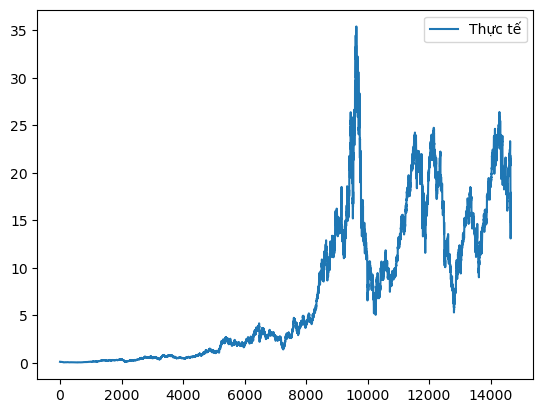

In [9]:
# Vẽ biểu đồ
plt.plot(data_HPQ, label='Thực tế')
plt.legend()
plt.show()

# Tiền xử lý HPQ

In [10]:
# Replace null values with 0
data_HPQ.fillna(0, inplace=True)

# Remove outliers by replacing values outside of 3 standard deviations with the mean
std = data_HPQ['Close'].std()
mean = data_HPQ['Close'].mean()
data_HPQ['Close'] = np.where(data_HPQ['Close'] > (mean + 10*std), mean, data_HPQ['Close'])
data_HPQ['Close'] = np.where(data_HPQ['Close'] < (mean - 10*std), mean, data_HPQ['Close'])

# # Scale data_AMZN to range [0, 1]
scaler = MinMaxScaler()
data_HPQ['Close'] = scaler.fit_transform(data_HPQ['Close'].values.reshape(-1, 1))

# Fill in missing values with the mean of the previous and next values
data_HPQ['Close'] = data_HPQ['Close'].interpolate(method='linear')

# Print the cleaned data_AMZN
print(data_HPQ)

          Close
0      0.001981
1      0.001944
2      0.001868
3      0.001793
4      0.001843
...         ...
14658  0.505705
14659  0.475169
14660  0.502878
14661  0.489306
14662  0.418056

[14663 rows x 1 columns]


In [11]:
data = data_HPQ

In [12]:
data

Close
0      0.001981
1      0.001944
2      0.001868
3      0.001793
4      0.001843
...         ...
14658  0.505705
14659  0.475169
14660  0.502878
14661  0.489306
14662  0.418056

[14663 rows x 1 columns]

In [13]:
# Chia dữ liệu thành train set và test set
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size, :]
test_data = data.iloc[train_size:, :]

In [14]:
#Xử lý dữ liệu thành dữ liệu đầu vào và đầu ra cho mô hình
def prepare_data(data, size_window,size_predict,stepWindow):
    X, y = [], []
    startWindow = 0
    for i in range(len(data) - size_window - 1):
        if (len(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0]) != size_predict):
            break
        X.append(data[startWindow:(startWindow + size_window), :])
        y.append(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0])
        print(data[startWindow:(startWindow + size_window), :])
        print("-----")
        print(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0])     
       
        startWindow += stepWindow
    return np.array(X), np.array(y)

size_window = 20
size_predict=1
stepWindow=1
X_train, y_train = prepare_data(train_data.values, size_window, size_predict, stepWindow)
X_test, y_test = prepare_data(test_data.values, size_window, size_predict, stepWindow)

[[0.00198119]
 [0.00194357]
 [0.00186834]
 [0.0017931 ]
 [0.00184326]
 [0.00189342]
 [0.0019185 ]
 [0.00190596]
 [0.00188088]
 [0.00183072]
 [0.0017931 ]
 [0.00178056]
 [0.00176802]
 [0.00195611]
 [0.00198119]
 [0.00193103]
 [0.00188088]
 [0.00188088]
 [0.00188088]
 [0.00180564]]
-----
[0.00184326]
[[0.00194357]
 [0.00186834]
 [0.0017931 ]
 [0.00184326]
 [0.00189342]
 [0.0019185 ]
 [0.00190596]
 [0.00188088]
 [0.00183072]
 [0.0017931 ]
 [0.00178056]
 [0.00176802]
 [0.00195611]
 [0.00198119]
 [0.00193103]
 [0.00188088]
 [0.00188088]
 [0.00188088]
 [0.00180564]
 [0.00184326]]
-----
[0.00189342]
[[0.00186834]
 [0.0017931 ]
 [0.00184326]
 [0.00189342]
 [0.0019185 ]
 [0.00190596]
 [0.00188088]
 [0.00183072]
 [0.0017931 ]
 [0.00178056]
 [0.00176802]
 [0.00195611]
 [0.00198119]
 [0.00193103]
 [0.00188088]
 [0.00188088]
 [0.00188088]
 [0.00180564]
 [0.00184326]
 [0.00189342]]
-----
[0.00184326]
[[0.0017931 ]
 [0.00184326]
 [0.00189342]
 [0.0019185 ]
 [0.00190596]
 [0.00188088]
 [0.00183072]
 [

[[0.0002884 ]
 [0.00030094]
 [0.00027586]
 [0.00030094]
 [0.00027586]
 [0.00032602]
 [0.00032602]
 [0.0002884 ]
 [0.00027586]
 [0.00033856]
 [0.00032602]
 [0.00032602]
 [0.00032602]
 [0.00032602]
 [0.00033856]
 [0.00033856]
 [0.0003511 ]
 [0.0003511 ]
 [0.00033856]
 [0.00036364]]
-----
[0.00040125]
[[0.00030094]
 [0.00027586]
 [0.00030094]
 [0.00027586]
 [0.00032602]
 [0.00032602]
 [0.0002884 ]
 [0.00027586]
 [0.00033856]
 [0.00032602]
 [0.00032602]
 [0.00032602]
 [0.00032602]
 [0.00033856]
 [0.00033856]
 [0.0003511 ]
 [0.0003511 ]
 [0.00033856]
 [0.00036364]
 [0.00040125]]
-----
[0.00037618]
[[0.00027586]
 [0.00030094]
 [0.00027586]
 [0.00032602]
 [0.00032602]
 [0.0002884 ]
 [0.00027586]
 [0.00033856]
 [0.00032602]
 [0.00032602]
 [0.00032602]
 [0.00032602]
 [0.00033856]
 [0.00033856]
 [0.0003511 ]
 [0.0003511 ]
 [0.00033856]
 [0.00036364]
 [0.00040125]
 [0.00037618]]
-----
[0.00040125]
[[0.00030094]
 [0.00027586]
 [0.00032602]
 [0.00032602]
 [0.0002884 ]
 [0.00027586]
 [0.00033856]
 [

[[0.00673354]
 [0.00644514]
 [0.00644514]
 [0.00642006]
 [0.00640752]
 [0.00642006]
 [0.00645768]
 [0.00640752]
 [0.00652038]
 [0.00668339]
 [0.00683386]
 [0.00683386]
 [0.00679624]
 [0.0068464 ]
 [0.0068464 ]
 [0.00689655]
 [0.0068464 ]
 [0.0068464 ]
 [0.00668339]
 [0.00667085]]
-----
[0.00654545]
[[0.00644514]
 [0.00644514]
 [0.00642006]
 [0.00640752]
 [0.00642006]
 [0.00645768]
 [0.00640752]
 [0.00652038]
 [0.00668339]
 [0.00683386]
 [0.00683386]
 [0.00679624]
 [0.0068464 ]
 [0.0068464 ]
 [0.00689655]
 [0.0068464 ]
 [0.0068464 ]
 [0.00668339]
 [0.00667085]
 [0.00654545]]
-----
[0.00645768]
[[0.00644514]
 [0.00642006]
 [0.00640752]
 [0.00642006]
 [0.00645768]
 [0.00640752]
 [0.00652038]
 [0.00668339]
 [0.00683386]
 [0.00683386]
 [0.00679624]
 [0.0068464 ]
 [0.0068464 ]
 [0.00689655]
 [0.0068464 ]
 [0.0068464 ]
 [0.00668339]
 [0.00667085]
 [0.00654545]
 [0.00645768]]
-----
[0.00640752]
[[0.00642006]
 [0.00640752]
 [0.00642006]
 [0.00645768]
 [0.00640752]
 [0.00652038]
 [0.00668339]
 [

[[0.00697179]
 [0.0070721 ]
 [0.00712226]
 [0.00712226]
 [0.00702194]
 [0.00647022]
 [0.00647022]
 [0.00669592]
 [0.00667085]
 [0.00667085]
 [0.00654545]
 [0.00644514]
 [0.00644514]
 [0.0064953 ]
 [0.00636991]
 [0.00636991]
 [0.00636991]
 [0.00659561]
 [0.00644514]
 [0.00662069]]
-----
[0.00659561]
[[0.0070721 ]
 [0.00712226]
 [0.00712226]
 [0.00702194]
 [0.00647022]
 [0.00647022]
 [0.00669592]
 [0.00667085]
 [0.00667085]
 [0.00654545]
 [0.00644514]
 [0.00644514]
 [0.0064953 ]
 [0.00636991]
 [0.00636991]
 [0.00636991]
 [0.00659561]
 [0.00644514]
 [0.00662069]
 [0.00659561]]
-----
[0.00662069]
[[0.00712226]
 [0.00712226]
 [0.00702194]
 [0.00647022]
 [0.00647022]
 [0.00669592]
 [0.00667085]
 [0.00667085]
 [0.00654545]
 [0.00644514]
 [0.00644514]
 [0.0064953 ]
 [0.00636991]
 [0.00636991]
 [0.00636991]
 [0.00659561]
 [0.00644514]
 [0.00662069]
 [0.00659561]
 [0.00662069]]
-----
[0.00674608]
[[0.00712226]
 [0.00702194]
 [0.00647022]
 [0.00647022]
 [0.00669592]
 [0.00667085]
 [0.00667085]
 [

[[0.01612539]
 [0.01562382]
 [0.01529781]
 [0.01534796]
 [0.01534796]
 [0.014721  ]
 [0.01477116]
 [0.01497179]
 [0.01497179]
 [0.01467085]
 [0.01462069]
 [0.01452038]
 [0.01341693]
 [0.01319122]
 [0.01406897]
 [0.01406897]
 [0.01426959]
 [0.01474608]
 [0.01454545]
 [0.01474608]]
-----
[0.01454545]
[[0.01562382]
 [0.01529781]
 [0.01534796]
 [0.01534796]
 [0.014721  ]
 [0.01477116]
 [0.01497179]
 [0.01497179]
 [0.01467085]
 [0.01462069]
 [0.01452038]
 [0.01341693]
 [0.01319122]
 [0.01406897]
 [0.01406897]
 [0.01426959]
 [0.01474608]
 [0.01454545]
 [0.01474608]
 [0.01454545]]
-----
[0.01421944]
[[0.01529781]
 [0.01534796]
 [0.01534796]
 [0.014721  ]
 [0.01477116]
 [0.01497179]
 [0.01497179]
 [0.01467085]
 [0.01462069]
 [0.01452038]
 [0.01341693]
 [0.01319122]
 [0.01406897]
 [0.01406897]
 [0.01426959]
 [0.01474608]
 [0.01454545]
 [0.01474608]
 [0.01454545]
 [0.01421944]]
-----
[0.01411912]
[[0.01534796]
 [0.01534796]
 [0.014721  ]
 [0.01477116]
 [0.01497179]
 [0.01497179]
 [0.01467085]
 [

[0.01868339]
[[0.01672727]
 [0.01742947]
 [0.01775548]
 [0.01752978]
 [0.01757994]
 [0.0178558 ]
 [0.01803135]
 [0.01850784]
 [0.01810658]
 [0.01783072]
 [0.01745454]
 [0.01757994]
 [0.01868339]
 [0.01875862]
 [0.01870846]
 [0.01921003]
 [0.01918495]
 [0.01868339]
 [0.01933542]
 [0.01868339]]
-----
[0.01885893]
[[0.01742947]
 [0.01775548]
 [0.01752978]
 [0.01757994]
 [0.0178558 ]
 [0.01803135]
 [0.01850784]
 [0.01810658]
 [0.01783072]
 [0.01745454]
 [0.01757994]
 [0.01868339]
 [0.01875862]
 [0.01870846]
 [0.01921003]
 [0.01918495]
 [0.01868339]
 [0.01933542]
 [0.01868339]
 [0.01885893]]
-----
[0.01835737]
[[0.01775548]
 [0.01752978]
 [0.01757994]
 [0.0178558 ]
 [0.01803135]
 [0.01850784]
 [0.01810658]
 [0.01783072]
 [0.01745454]
 [0.01757994]
 [0.01868339]
 [0.01875862]
 [0.01870846]
 [0.01921003]
 [0.01918495]
 [0.01868339]
 [0.01933542]
 [0.01868339]
 [0.01885893]
 [0.01835737]]
-----
[0.0182069]
[[0.01752978]
 [0.01757994]
 [0.0178558 ]
 [0.01803135]
 [0.01850784]
 [0.01810658]
 [0.

[[0.01281505]
 [0.01278997]
 [0.01291536]
 [0.01316614]
 [0.01329154]
 [0.01329154]
 [0.01331661]
 [0.01336677]
 [0.01316614]
 [0.01296552]
 [0.01273981]
 [0.01261442]
 [0.0126395 ]
 [0.01258934]
 [0.01251411]
 [0.01241379]
 [0.01246395]
 [0.01241379]
 [0.01246395]
 [0.01243887]]
-----
[0.0126395]
[[0.01278997]
 [0.01291536]
 [0.01316614]
 [0.01329154]
 [0.01329154]
 [0.01331661]
 [0.01336677]
 [0.01316614]
 [0.01296552]
 [0.01273981]
 [0.01261442]
 [0.0126395 ]
 [0.01258934]
 [0.01251411]
 [0.01241379]
 [0.01246395]
 [0.01241379]
 [0.01246395]
 [0.01243887]
 [0.0126395 ]]
-----
[0.01258934]
[[0.01291536]
 [0.01316614]
 [0.01329154]
 [0.01329154]
 [0.01331661]
 [0.01336677]
 [0.01316614]
 [0.01296552]
 [0.01273981]
 [0.01261442]
 [0.0126395 ]
 [0.01258934]
 [0.01251411]
 [0.01241379]
 [0.01246395]
 [0.01241379]
 [0.01246395]
 [0.01243887]
 [0.0126395 ]
 [0.01258934]]
-----
[0.01251411]
[[0.01316614]
 [0.01329154]
 [0.01329154]
 [0.01331661]
 [0.01336677]
 [0.01316614]
 [0.01296552]
 [0

[[0.02164263]
 [0.02149216]
 [0.02184326]
 [0.02174295]
 [0.02154232]
 [0.02119122]
 [0.02134169]
 [0.02204389]
 [0.0217931 ]
 [0.02154232]
 [0.02134169]
 [0.02099059]
 [0.02104075]
 [0.02094044]
 [0.02109091]
 [0.02114107]
 [0.02109091]
 [0.02144201]
 [0.02134169]
 [0.02159248]]
-----
[0.02189342]
[[0.02149216]
 [0.02184326]
 [0.02174295]
 [0.02154232]
 [0.02119122]
 [0.02134169]
 [0.02204389]
 [0.0217931 ]
 [0.02154232]
 [0.02134169]
 [0.02099059]
 [0.02104075]
 [0.02094044]
 [0.02109091]
 [0.02114107]
 [0.02109091]
 [0.02144201]
 [0.02134169]
 [0.02159248]
 [0.02189342]]
-----
[0.02274608]
[[0.02184326]
 [0.02174295]
 [0.02154232]
 [0.02119122]
 [0.02134169]
 [0.02204389]
 [0.0217931 ]
 [0.02154232]
 [0.02134169]
 [0.02099059]
 [0.02104075]
 [0.02094044]
 [0.02109091]
 [0.02114107]
 [0.02109091]
 [0.02144201]
 [0.02134169]
 [0.02159248]
 [0.02189342]
 [0.02274608]]
-----
[0.02289655]
[[0.02174295]
 [0.02154232]
 [0.02119122]
 [0.02134169]
 [0.02204389]
 [0.0217931 ]
 [0.02154232]
 [

[[0.04983072]
 [0.04832602]
 [0.04882758]
 [0.04642006]
 [0.04652038]
 [0.0474232 ]
 [0.04702194]
 [0.05113479]
 [0.05053291]
 [0.05023197]
 [0.0474232 ]
 [0.04902821]
 [0.04942947]
 [0.0482257 ]
 [0.0482257 ]
 [0.04983072]
 [0.05053291]
 [0.05394357]
 [0.05324138]
 [0.05404389]]
-----
[0.05424451]
[[0.04832602]
 [0.04882758]
 [0.04642006]
 [0.04652038]
 [0.0474232 ]
 [0.04702194]
 [0.05113479]
 [0.05053291]
 [0.05023197]
 [0.0474232 ]
 [0.04902821]
 [0.04942947]
 [0.0482257 ]
 [0.0482257 ]
 [0.04983072]
 [0.05053291]
 [0.05394357]
 [0.05324138]
 [0.05404389]
 [0.05424451]]
-----
[0.05524765]
[[0.04882758]
 [0.04642006]
 [0.04652038]
 [0.0474232 ]
 [0.04702194]
 [0.05113479]
 [0.05053291]
 [0.05023197]
 [0.0474232 ]
 [0.04902821]
 [0.04942947]
 [0.0482257 ]
 [0.0482257 ]
 [0.04983072]
 [0.05053291]
 [0.05394357]
 [0.05324138]
 [0.05404389]
 [0.05424451]
 [0.05524765]]
-----
[0.05314107]
[[0.04642006]
 [0.04652038]
 [0.0474232 ]
 [0.04702194]
 [0.05113479]
 [0.05053291]
 [0.05023197]
 [

[[0.05845768]
 [0.05625078]
 [0.05705329]
 [0.05645141]
 [0.05645141]
 [0.05464577]
 [0.05344201]
 [0.05344201]
 [0.05544828]
 [0.05464577]
 [0.05424451]
 [0.05344201]
 [0.05444514]
 [0.05444514]
 [0.05444514]
 [0.05605016]
 [0.05685266]
 [0.05605016]
 [0.05705329]
 [0.05926018]]
-----
[0.06186834]
[[0.05625078]
 [0.05705329]
 [0.05645141]
 [0.05645141]
 [0.05464577]
 [0.05344201]
 [0.05344201]
 [0.05544828]
 [0.05464577]
 [0.05424451]
 [0.05344201]
 [0.05444514]
 [0.05444514]
 [0.05444514]
 [0.05605016]
 [0.05685266]
 [0.05605016]
 [0.05705329]
 [0.05926018]
 [0.06186834]]
-----
[0.0638746]
[[0.05705329]
 [0.05645141]
 [0.05645141]
 [0.05464577]
 [0.05344201]
 [0.05344201]
 [0.05544828]
 [0.05464577]
 [0.05424451]
 [0.05344201]
 [0.05444514]
 [0.05444514]
 [0.05444514]
 [0.05605016]
 [0.05685266]
 [0.05605016]
 [0.05705329]
 [0.05926018]
 [0.06186834]
 [0.0638746 ]]
-----
[0.0638746]
[[0.05645141]
 [0.05645141]
 [0.05464577]
 [0.05344201]
 [0.05344201]
 [0.05544828]
 [0.05464577]
 [0.

[[0.07129781]
 [0.07410658]
 [0.07470846]
 [0.07531034]
 [0.07270219]
 [0.07109717]
 [0.0682884 ]
 [0.06889028]
 [0.07089655]
 [0.06929153]
 [0.07089655]
 [0.07109717]
 [0.07109717]
 [0.06989341]
 [0.06909091]
 [0.06949216]
 [0.06768652]
 [0.06788715]
 [0.06889028]
 [0.06949216]]
-----
[0.06788715]
[[0.07410658]
 [0.07470846]
 [0.07531034]
 [0.07270219]
 [0.07109717]
 [0.0682884 ]
 [0.06889028]
 [0.07089655]
 [0.06929153]
 [0.07089655]
 [0.07109717]
 [0.07109717]
 [0.06989341]
 [0.06909091]
 [0.06949216]
 [0.06768652]
 [0.06788715]
 [0.06889028]
 [0.06949216]
 [0.06788715]]
-----
[0.06969279]
[[0.07470846]
 [0.07531034]
 [0.07270219]
 [0.07109717]
 [0.0682884 ]
 [0.06889028]
 [0.07089655]
 [0.06929153]
 [0.07089655]
 [0.07109717]
 [0.07109717]
 [0.06989341]
 [0.06909091]
 [0.06949216]
 [0.06768652]
 [0.06788715]
 [0.06889028]
 [0.06949216]
 [0.06788715]
 [0.06969279]]
-----
[0.06969279]
[[0.07531034]
 [0.07270219]
 [0.07109717]
 [0.0682884 ]
 [0.06889028]
 [0.07089655]
 [0.06929153]
 [

[[0.09737931]
 [0.10219436]
 [0.1009906 ]
 [0.10038872]
 [0.0995862 ]
 [0.09918495]
 [0.10199373]
 [0.09798119]
 [0.09838244]
 [0.10058934]
 [0.10119122]
 [0.10279624]
 [0.10119122]
 [0.09778056]
 [0.09998746]
 [0.09978683]
 [0.09878369]
 [0.09597492]
 [0.0943699 ]
 [0.09457053]]
-----
[0.09597492]
[[0.10219436]
 [0.1009906 ]
 [0.10038872]
 [0.0995862 ]
 [0.09918495]
 [0.10199373]
 [0.09798119]
 [0.09838244]
 [0.10058934]
 [0.10119122]
 [0.10279624]
 [0.10119122]
 [0.09778056]
 [0.09998746]
 [0.09978683]
 [0.09878369]
 [0.09597492]
 [0.0943699 ]
 [0.09457053]
 [0.09597492]]
-----
[0.09637617]
[[0.1009906 ]
 [0.10038872]
 [0.0995862 ]
 [0.09918495]
 [0.10199373]
 [0.09798119]
 [0.09838244]
 [0.10058934]
 [0.10119122]
 [0.10279624]
 [0.10119122]
 [0.09778056]
 [0.09998746]
 [0.09978683]
 [0.09878369]
 [0.09597492]
 [0.0943699 ]
 [0.09457053]
 [0.09597492]
 [0.09637617]]
-----
[0.09597492]
[[0.10038872]
 [0.0995862 ]
 [0.09918495]
 [0.10199373]
 [0.09798119]
 [0.09838244]
 [0.10058934]
 [

[[0.07510971]
 [0.07510971]
 [0.07671473]
 [0.07811912]
 [0.07691536]
 [0.07811912]
 [0.07751724]
 [0.07611285]
 [0.07611285]
 [0.07591222]
 [0.07531034]
 [0.07470846]
 [0.07330407]
 [0.07490909]
 [0.07591222]
 [0.07510971]
 [0.07370533]
 [0.07290282]
 [0.07310345]
 [0.07270219]]
-----
[0.07450783]
[[0.07510971]
 [0.07671473]
 [0.07811912]
 [0.07691536]
 [0.07811912]
 [0.07751724]
 [0.07611285]
 [0.07611285]
 [0.07591222]
 [0.07531034]
 [0.07470846]
 [0.07330407]
 [0.07490909]
 [0.07591222]
 [0.07510971]
 [0.07370533]
 [0.07290282]
 [0.07310345]
 [0.07270219]
 [0.07450783]]
-----
[0.07430721]
[[0.07671473]
 [0.07811912]
 [0.07691536]
 [0.07811912]
 [0.07751724]
 [0.07611285]
 [0.07611285]
 [0.07591222]
 [0.07531034]
 [0.07470846]
 [0.07330407]
 [0.07490909]
 [0.07591222]
 [0.07510971]
 [0.07370533]
 [0.07290282]
 [0.07310345]
 [0.07270219]
 [0.07450783]
 [0.07430721]]
-----
[0.07510971]
[[0.07811912]
 [0.07691536]
 [0.07811912]
 [0.07751724]
 [0.07611285]
 [0.07611285]
 [0.07591222]
 [

[0.12827586]
[[0.12145455]
 [0.12085267]
 [0.12105329]
 [0.12265831]
 [0.12245768]
 [0.12506583]
 [0.12667084]
 [0.12807523]
 [0.130884  ]
 [0.13188714]
 [0.13289028]
 [0.13048275]
 [0.12747335]
 [0.12687147]
 [0.12626959]
 [0.12767398]
 [0.1270721 ]
 [0.12847648]
 [0.12687147]
 [0.12827586]]
-----
[0.12546708]
[[0.12085267]
 [0.12105329]
 [0.12265831]
 [0.12245768]
 [0.12506583]
 [0.12667084]
 [0.12807523]
 [0.130884  ]
 [0.13188714]
 [0.13289028]
 [0.13048275]
 [0.12747335]
 [0.12687147]
 [0.12626959]
 [0.12767398]
 [0.1270721 ]
 [0.12847648]
 [0.12687147]
 [0.12827586]
 [0.12546708]]
-----
[0.12245768]
[[0.12105329]
 [0.12265831]
 [0.12245768]
 [0.12506583]
 [0.12667084]
 [0.12807523]
 [0.130884  ]
 [0.13188714]
 [0.13289028]
 [0.13048275]
 [0.12747335]
 [0.12687147]
 [0.12626959]
 [0.12767398]
 [0.1270721 ]
 [0.12847648]
 [0.12687147]
 [0.12827586]
 [0.12546708]
 [0.12245768]]
-----
[0.12466458]
[[0.12265831]
 [0.12245768]
 [0.12506583]
 [0.12667084]
 [0.12807523]
 [0.130884  ]
 [0

[0.13610031]
[[0.12947962]
 [0.13168651]
 [0.13248903]
 [0.13409405]
 [0.13469593]
 [0.13569906]
 [0.13890909]
 [0.13850783]
 [0.13690282]
 [0.13409405]
 [0.13188714]
 [0.1344953 ]
 [0.13309091]
 [0.13168651]
 [0.13068338]
 [0.13148588]
 [0.13489655]
 [0.13529781]
 [0.13349216]
 [0.13610031]]
-----
[0.13329154]
[[0.13168651]
 [0.13248903]
 [0.13409405]
 [0.13469593]
 [0.13569906]
 [0.13890909]
 [0.13850783]
 [0.13690282]
 [0.13409405]
 [0.13188714]
 [0.1344953 ]
 [0.13309091]
 [0.13168651]
 [0.13068338]
 [0.13148588]
 [0.13489655]
 [0.13529781]
 [0.13349216]
 [0.13610031]
 [0.13329154]]
-----
[0.12847648]
[[0.13248903]
 [0.13409405]
 [0.13469593]
 [0.13569906]
 [0.13890909]
 [0.13850783]
 [0.13690282]
 [0.13409405]
 [0.13188714]
 [0.1344953 ]
 [0.13309091]
 [0.13168651]
 [0.13068338]
 [0.13148588]
 [0.13489655]
 [0.13529781]
 [0.13349216]
 [0.13610031]
 [0.13329154]
 [0.12847648]]
-----
[0.130884]
[[0.13409405]
 [0.13469593]
 [0.13569906]
 [0.13890909]
 [0.13850783]
 [0.13690282]
 [0.1

[0.21474608]
[[0.20872727]
 [0.20912852]
 [0.20792476]
 [0.20952977]
 [0.21073353]
 [0.20471473]
 [0.20511599]
 [0.21514733]
 [0.21354231]
 [0.21233855]
 [0.21354231]
 [0.21354231]
 [0.2171536 ]
 [0.21755486]
 [0.21795611]
 [0.22638244]
 [0.22156739]
 [0.22397491]
 [0.21875862]
 [0.21474608]]
-----
[0.22036363]
[[0.20912852]
 [0.20792476]
 [0.20952977]
 [0.21073353]
 [0.20471473]
 [0.20511599]
 [0.21514733]
 [0.21354231]
 [0.21233855]
 [0.21354231]
 [0.21354231]
 [0.2171536 ]
 [0.21755486]
 [0.21795611]
 [0.22638244]
 [0.22156739]
 [0.22397491]
 [0.21875862]
 [0.21474608]
 [0.22036363]]
-----
[0.22557994]
[[0.20792476]
 [0.20952977]
 [0.21073353]
 [0.20471473]
 [0.20511599]
 [0.21514733]
 [0.21354231]
 [0.21233855]
 [0.21354231]
 [0.21354231]
 [0.2171536 ]
 [0.21755486]
 [0.21795611]
 [0.22638244]
 [0.22156739]
 [0.22397491]
 [0.21875862]
 [0.21474608]
 [0.22036363]
 [0.22557994]]
-----
[0.22357366]
[[0.20952977]
 [0.21073353]
 [0.20471473]
 [0.20511599]
 [0.21514733]
 [0.21354231]
 [0

[[0.33311597]
 [0.33552349]
 [0.34033856]
 [0.33873354]
 [0.34354859]
 [0.33873354]
 [0.34435109]
 [0.35157365]
 [0.34595611]
 [0.35398117]
 [0.34956739]
 [0.3451536 ]
 [0.34876488]
 [0.35799371]
 [0.35077115]
 [0.35357992]
 [0.36040126]
 [0.36361128]
 [0.36922883]
 [0.37083385]]
-----
[0.37284011]
[[0.33552349]
 [0.34033856]
 [0.33873354]
 [0.34354859]
 [0.33873354]
 [0.34435109]
 [0.35157365]
 [0.34595611]
 [0.35398117]
 [0.34956739]
 [0.3451536 ]
 [0.34876488]
 [0.35799371]
 [0.35077115]
 [0.35357992]
 [0.36040126]
 [0.36361128]
 [0.36922883]
 [0.37083385]
 [0.37284011]]
-----
[0.39009404]
[[0.34033856]
 [0.33873354]
 [0.34354859]
 [0.33873354]
 [0.34435109]
 [0.35157365]
 [0.34595611]
 [0.35398117]
 [0.34956739]
 [0.3451536 ]
 [0.34876488]
 [0.35799371]
 [0.35077115]
 [0.35357992]
 [0.36040126]
 [0.36361128]
 [0.36922883]
 [0.37083385]
 [0.37284011]
 [0.39009404]]
-----
[0.41617554]
[[0.33873354]
 [0.34354859]
 [0.33873354]
 [0.34435109]
 [0.35157365]
 [0.34595611]
 [0.35398117]
 [

[[0.43262696]
 [0.43944827]
 [0.44546707]
 [0.44145453]
 [0.43383072]
 [0.43423197]
 [0.45710342]
 [0.44787459]
 [0.44626957]
 [0.45630091]
 [0.44546707]
 [0.437442  ]
 [0.45309088]
 [0.45429467]
 [0.45268966]
 [0.45028211]
 [0.45670219]
 [0.45670219]
 [0.4807774 ]
 [0.49040753]]
-----
[0.49361756]
[[0.43944827]
 [0.44546707]
 [0.44145453]
 [0.43383072]
 [0.43423197]
 [0.45710342]
 [0.44787459]
 [0.44626957]
 [0.45630091]
 [0.44546707]
 [0.437442  ]
 [0.45309088]
 [0.45429467]
 [0.45268966]
 [0.45028211]
 [0.45670219]
 [0.45670219]
 [0.4807774 ]
 [0.49040753]
 [0.49361756]]
-----
[0.50886519]
[[0.44546707]
 [0.44145453]
 [0.43383072]
 [0.43423197]
 [0.45710342]
 [0.44787459]
 [0.44626957]
 [0.45630091]
 [0.44546707]
 [0.437442  ]
 [0.45309088]
 [0.45429467]
 [0.45268966]
 [0.45028211]
 [0.45670219]
 [0.45670219]
 [0.4807774 ]
 [0.49040753]
 [0.49361756]
 [0.50886519]]
-----
[0.51287773]
[[0.44145453]
 [0.43383072]
 [0.43423197]
 [0.45710342]
 [0.44787459]
 [0.44626957]
 [0.45630091]
 [

[[0.31125568]
 [0.30932966]
 [0.31510769]
 [0.32602181]
 [0.33115786]
 [0.32319699]
 [0.32242657]
 [0.32101416]
 [0.31626332]
 [0.31562131]
 [0.32075736]
 [0.31780414]
 [0.31767573]
 [0.30791725]
 [0.30830243]
 [0.30727523]
 [0.31613492]
 [0.31562131]
 [0.3130533 ]
 [0.30676162]]
-----
[0.32114257]
[[0.30932966]
 [0.31510769]
 [0.32602181]
 [0.33115786]
 [0.32319699]
 [0.32242657]
 [0.32101416]
 [0.31626332]
 [0.31562131]
 [0.32075736]
 [0.31780414]
 [0.31767573]
 [0.30791725]
 [0.30830243]
 [0.30727523]
 [0.31613492]
 [0.31562131]
 [0.3130533 ]
 [0.30676162]
 [0.32114257]]
-----
[0.31973016]
[[0.31510769]
 [0.32602181]
 [0.33115786]
 [0.32319699]
 [0.32242657]
 [0.32101416]
 [0.31626332]
 [0.31562131]
 [0.32075736]
 [0.31780414]
 [0.31767573]
 [0.30791725]
 [0.30830243]
 [0.30727523]
 [0.31613492]
 [0.31562131]
 [0.3130533 ]
 [0.30676162]
 [0.32114257]
 [0.31973016]]
-----
[0.31446571]
[[0.32602181]
 [0.33115786]
 [0.32319699]
 [0.32242657]
 [0.32101416]
 [0.31626332]
 [0.31562131]
 [

[[0.19954658]
 [0.20904827]
 [0.21341392]
 [0.21623874]
 [0.21893516]
 [0.22330081]
 [0.21097428]
 [0.21046068]
 [0.21135949]
 [0.20956187]
 [0.20712225]
 [0.19813416]
 [0.19903297]
 [0.20378382]
 [0.20853466]
 [0.20789266]
 [0.20660865]
 [0.20070218]
 [0.19569454]
 [0.19839097]]
-----
[0.19492413]
[[0.20904827]
 [0.21341392]
 [0.21623874]
 [0.21893516]
 [0.22330081]
 [0.21097428]
 [0.21046068]
 [0.21135949]
 [0.20956187]
 [0.20712225]
 [0.19813416]
 [0.19903297]
 [0.20378382]
 [0.20853466]
 [0.20789266]
 [0.20660865]
 [0.20070218]
 [0.19569454]
 [0.19839097]
 [0.19492413]]
-----
[0.2024998]
[[0.21341392]
 [0.21623874]
 [0.21893516]
 [0.22330081]
 [0.21097428]
 [0.21046068]
 [0.21135949]
 [0.20956187]
 [0.20712225]
 [0.19813416]
 [0.19903297]
 [0.20378382]
 [0.20853466]
 [0.20789266]
 [0.20660865]
 [0.20070218]
 [0.19569454]
 [0.19839097]
 [0.19492413]
 [0.2024998 ]]
-----
[0.19839097]
[[0.21623874]
 [0.21893516]
 [0.22330081]
 [0.21097428]
 [0.21046068]
 [0.21135949]
 [0.20956187]
 [0

[[0.37340188]
 [0.36980665]
 [0.36916463]
 [0.36890782]
 [0.36788063]
 [0.36954984]
 [0.36788063]
 [0.36749542]
 [0.36826583]
 [0.36749542]
 [0.36608301]
 [0.36788063]
 [0.37866631]
 [0.3759699 ]
 [0.38675561]
 [0.39163485]
 [0.39368928]
 [0.40087975]
 [0.3967709 ]
 [0.4080702 ]]
-----
[0.40498857]
[[0.36980665]
 [0.36916463]
 [0.36890782]
 [0.36788063]
 [0.36954984]
 [0.36788063]
 [0.36749542]
 [0.36826583]
 [0.36749542]
 [0.36608301]
 [0.36788063]
 [0.37866631]
 [0.3759699 ]
 [0.38675561]
 [0.39163485]
 [0.39368928]
 [0.40087975]
 [0.3967709 ]
 [0.4080702 ]
 [0.40498857]]
-----
[0.40511698]
[[0.36916463]
 [0.36890782]
 [0.36788063]
 [0.36954984]
 [0.36788063]
 [0.36749542]
 [0.36826583]
 [0.36749542]
 [0.36608301]
 [0.36788063]
 [0.37866631]
 [0.3759699 ]
 [0.38675561]
 [0.39163485]
 [0.39368928]
 [0.40087975]
 [0.3967709 ]
 [0.4080702 ]
 [0.40498857]
 [0.40511698]]
-----
[0.41243585]
[[0.36890782]
 [0.36788063]
 [0.36954984]
 [0.36788063]
 [0.36749542]
 [0.36826583]
 [0.36749542]
 [

[[0.65524264]
 [0.65537099]
 [0.66654191]
 [0.67026555]
 [0.67604359]
 [0.66114908]
 [0.65793906]
 [0.64663973]
 [0.63598242]
 [0.63598242]
 [0.60028686]
 [0.58076988]
 [0.55303521]
 [0.5690854 ]
 [0.58064148]
 [0.57627582]
 [0.59078518]
 [0.57691784]
 [0.56780137]
 [0.5505956 ]]
-----
[0.56022569]
[[0.65537099]
 [0.66654191]
 [0.67026555]
 [0.67604359]
 [0.66114908]
 [0.65793906]
 [0.64663973]
 [0.63598242]
 [0.63598242]
 [0.60028686]
 [0.58076988]
 [0.55303521]
 [0.5690854 ]
 [0.58064148]
 [0.57627582]
 [0.59078518]
 [0.57691784]
 [0.56780137]
 [0.5505956 ]
 [0.56022569]]
-----
[0.54700037]
[[0.66654191]
 [0.67026555]
 [0.67604359]
 [0.66114908]
 [0.65793906]
 [0.64663973]
 [0.63598242]
 [0.63598242]
 [0.60028686]
 [0.58076988]
 [0.55303521]
 [0.5690854 ]
 [0.58064148]
 [0.57627582]
 [0.59078518]
 [0.57691784]
 [0.56780137]
 [0.5505956 ]
 [0.56022569]
 [0.54700037]]
-----
[0.55303521]
[[0.67026555]
 [0.67604359]
 [0.66114908]
 [0.65793906]
 [0.64663973]
 [0.63598242]
 [0.63598242]
 [

[[0.5401951 ]
 [0.54687196]
 [0.55444765]
 [0.55547482]
 [0.55598843]
 [0.55393404]
 [0.54045191]
 [0.55752927]
 [0.55919846]
 [0.55560322]
 [0.56574692]
 [0.56792977]
 [0.56459134]
 [0.55200799]
 [0.5629221 ]
 [0.56125291]
 [0.56317891]
 [0.57345101]
 [0.57357941]
 [0.57216703]]
-----
[0.56959896]
[[0.54687196]
 [0.55444765]
 [0.55547482]
 [0.55598843]
 [0.55393404]
 [0.54045191]
 [0.55752927]
 [0.55919846]
 [0.55560322]
 [0.56574692]
 [0.56792977]
 [0.56459134]
 [0.55200799]
 [0.5629221 ]
 [0.56125291]
 [0.56317891]
 [0.57345101]
 [0.57357941]
 [0.57216703]
 [0.56959896]]
-----
[0.57383622]
[[0.55444765]
 [0.55547482]
 [0.55598843]
 [0.55393404]
 [0.54045191]
 [0.55752927]
 [0.55919846]
 [0.55560322]
 [0.56574692]
 [0.56792977]
 [0.56459134]
 [0.55200799]
 [0.5629221 ]
 [0.56125291]
 [0.56317891]
 [0.57345101]
 [0.57357941]
 [0.57216703]
 [0.56959896]
 [0.57383622]]
-----
[0.5731942]
[[0.55547482]
 [0.55598843]
 [0.55393404]
 [0.54045191]
 [0.55752927]
 [0.55919846]
 [0.55560322]
 [0

[[0.45570705]
 [0.45146985]
 [0.46366795]
 [0.46970279]
 [0.47471046]
 [0.47958968]
 [0.47098682]
 [0.46366795]
 [0.45005742]
 [0.45044263]
 [0.43952851]
 [0.43862972]
 [0.4162879 ]
 [0.4174435 ]
 [0.39407449]
 [0.40331936]
 [0.38187636]
 [0.39715611]
 [0.41346305]
 [0.41487546]]
-----
[0.41718669]
[[0.45146985]
 [0.46366795]
 [0.46970279]
 [0.47471046]
 [0.47958968]
 [0.47098682]
 [0.46366795]
 [0.45005742]
 [0.45044263]
 [0.43952851]
 [0.43862972]
 [0.4162879 ]
 [0.4174435 ]
 [0.39407449]
 [0.40331936]
 [0.38187636]
 [0.39715611]
 [0.41346305]
 [0.41487546]
 [0.41718669]]
-----
[0.40152174]
[[0.46366795]
 [0.46970279]
 [0.47471046]
 [0.47958968]
 [0.47098682]
 [0.46366795]
 [0.45005742]
 [0.45044263]
 [0.43952851]
 [0.43862972]
 [0.4162879 ]
 [0.4174435 ]
 [0.39407449]
 [0.40331936]
 [0.38187636]
 [0.39715611]
 [0.41346305]
 [0.41487546]
 [0.41718669]
 [0.40152174]]
-----
[0.3773823]
[[0.46970279]
 [0.47471046]
 [0.47958968]
 [0.47098682]
 [0.46366795]
 [0.45005742]
 [0.45044263]
 [0

[[0.17836037]
 [0.17977279]
 [0.17874558]
 [0.17412313]
 [0.18144201]
 [0.19132889]
 [0.19286971]
 [0.19286971]
 [0.19325492]
 [0.19607975]
 [0.2019862 ]
 [0.20750746]
 [0.20596664]
 [0.21611035]
 [0.21071749]
 [0.21944878]
 [0.21816476]
 [0.21816476]
 [0.21996238]
 [0.21688075]]
-----
[0.21688075]
[[0.17977279]
 [0.17874558]
 [0.17412313]
 [0.18144201]
 [0.19132889]
 [0.19286971]
 [0.19286971]
 [0.19325492]
 [0.19607975]
 [0.2019862 ]
 [0.20750746]
 [0.20596664]
 [0.21611035]
 [0.21071749]
 [0.21944878]
 [0.21816476]
 [0.21816476]
 [0.21996238]
 [0.21688075]
 [0.21688075]]
-----
[0.21662395]
[[0.17874558]
 [0.17412313]
 [0.18144201]
 [0.19132889]
 [0.19286971]
 [0.19286971]
 [0.19325492]
 [0.19607975]
 [0.2019862 ]
 [0.20750746]
 [0.20596664]
 [0.21611035]
 [0.21071749]
 [0.21944878]
 [0.21816476]
 [0.21816476]
 [0.21996238]
 [0.21688075]
 [0.21688075]
 [0.21662395]]
-----
[0.21700914]
[[0.17412313]
 [0.18144201]
 [0.19132889]
 [0.19286971]
 [0.19286971]
 [0.19325492]
 [0.19607975]
 [

[[0.41487546]
 [0.41423347]
 [0.41487546]
 [0.42257955]
 [0.42013992]
 [0.42578958]
 [0.42797241]
 [0.42617479]
 [0.41192224]
 [0.40948263]
 [0.40280575]
 [0.40383297]
 [0.39856852]
 [0.40023773]
 [0.40165014]
 [0.4071714 ]
 [0.40190695]
 [0.40319096]
 [0.40357616]
 [0.41076664]]
-----
[0.4183423]
[[0.41423347]
 [0.41487546]
 [0.42257955]
 [0.42013992]
 [0.42578958]
 [0.42797241]
 [0.42617479]
 [0.41192224]
 [0.40948263]
 [0.40280575]
 [0.40383297]
 [0.39856852]
 [0.40023773]
 [0.40165014]
 [0.4071714 ]
 [0.40190695]
 [0.40319096]
 [0.40357616]
 [0.41076664]
 [0.4183423 ]]
-----
[0.41603109]
[[0.41487546]
 [0.42257955]
 [0.42013992]
 [0.42578958]
 [0.42797241]
 [0.42617479]
 [0.41192224]
 [0.40948263]
 [0.40280575]
 [0.40383297]
 [0.39856852]
 [0.40023773]
 [0.40165014]
 [0.4071714 ]
 [0.40190695]
 [0.40319096]
 [0.40357616]
 [0.41076664]
 [0.4183423 ]
 [0.41603109]]
-----
[0.42270795]
[[0.42257955]
 [0.42013992]
 [0.42578958]
 [0.42797241]
 [0.42617479]
 [0.41192224]
 [0.40948263]
 [0

[0.53454439]
[[0.52521398]
 [0.52917238]
 [0.53058605]
 [0.5336962 ]
 [0.53284797]
 [0.53030331]
 [0.52973787]
 [0.53313071]
 [0.54444028]
 [0.54246112]
 [0.54585401]
 [0.54302661]
 [0.54415754]
 [0.54585401]
 [0.54896411]
 [0.53454439]
 [0.52945512]
 [0.53567537]
 [0.53878552]
 [0.53454439]]
-----
[0.53595812]
[[0.52917238]
 [0.53058605]
 [0.5336962 ]
 [0.53284797]
 [0.53030331]
 [0.52973787]
 [0.53313071]
 [0.54444028]
 [0.54246112]
 [0.54585401]
 [0.54302661]
 [0.54415754]
 [0.54585401]
 [0.54896411]
 [0.53454439]
 [0.52945512]
 [0.53567537]
 [0.53878552]
 [0.53454439]
 [0.53595812]]
-----
[0.5178628]
[[0.53058605]
 [0.5336962 ]
 [0.53284797]
 [0.53030331]
 [0.52973787]
 [0.53313071]
 [0.54444028]
 [0.54246112]
 [0.54585401]
 [0.54302661]
 [0.54415754]
 [0.54585401]
 [0.54896411]
 [0.53454439]
 [0.52945512]
 [0.53567537]
 [0.53878552]
 [0.53454439]
 [0.53595812]
 [0.5178628 ]]
-----
[0.52069016]
[[0.5336962 ]
 [0.53284797]
 [0.53030331]
 [0.52973787]
 [0.53313071]
 [0.54444028]
 [0.

[[0.7211525 ]
 [0.73274482]
 [0.72313167]
 [0.72709006]
 [0.72228349]
 [0.73585497]
 [0.73528948]
 [0.74546812]
 [0.71493225]
 [0.70560185]
 [0.70447087]
 [0.68439638]
 [0.64905394]
 [0.66771475]
 [0.66460459]
 [0.67591417]
 [0.67336956]
 [0.67054215]
 [0.67252132]
 [0.6801553 ]]
-----
[0.67534873]
[[0.73274482]
 [0.72313167]
 [0.72709006]
 [0.72228349]
 [0.73585497]
 [0.73528948]
 [0.74546812]
 [0.71493225]
 [0.70560185]
 [0.70447087]
 [0.68439638]
 [0.64905394]
 [0.66771475]
 [0.66460459]
 [0.67591417]
 [0.67336956]
 [0.67054215]
 [0.67252132]
 [0.6801553 ]
 [0.67534873]]
-----
[0.65046762]
[[0.72313167]
 [0.72709006]
 [0.72228349]
 [0.73585497]
 [0.73528948]
 [0.74546812]
 [0.71493225]
 [0.70560185]
 [0.70447087]
 [0.68439638]
 [0.64905394]
 [0.66771475]
 [0.66460459]
 [0.67591417]
 [0.67336956]
 [0.67054215]
 [0.67252132]
 [0.6801553 ]
 [0.67534873]
 [0.65046762]]
-----
[0.67110764]
[[0.72709006]
 [0.72228349]
 [0.73585497]
 [0.73528948]
 [0.74546812]
 [0.71493225]
 [0.70560185]
 [

In [15]:
# Fucntion Tính khoảng cách giữa 2 chuỗi thời gian
# ts1 chuỗi thứ nhất
# ts2 chuỗi thứ 2
def euclidean_distance(ts1, ts2):
    ts1= np.array(ts1)
    ts2= np.array(ts2)
    return np.linalg.norm(ts1-ts2)

In [16]:
# function lấy ra k chuỗi gần nhất
# k số lượng chuỗi gần nhất
# distanceArr mảng khoảng cách
def kSimilarityTimeSeries(k, distanceArr):
    distances = np.array(distanceArr)
    return distances.argsort()[:k] 

In [17]:
# Tính khoảng cách DTW
def dtw_dist(x, y):
    dist, _, _, _ = dtw(x, y, dist=lambda x, y: np.abs(x - y))
    return dist

In [18]:
def ToTrain(X_train, y_train, xTest, yTest):
    X_train.append(xTest)
    y_train.append(yTest)
    return np.array(X_train), np.array(y_train)

In [19]:
#Dự đoán
def predict(k, X_train, y_train, X_test, y_test):
    y_pred_arr=[]
    for iTest in range(len(X_test)):
        if(k>len(X_train)):
            k=len(X_train)
        distanceArr=[]
        for iTrain in range(len(X_train)-size_window+2):
            distance = dtw_dist(X_test[iTest],X_train[iTrain])
            distanceArr.append(distance)

        indexKNN= kSimilarityTimeSeries(k,distanceArr)
        # Dự đoán
        y_pred = np.mean(y_train[indexKNN])
        y_pred_arr.append(y_pred)
        X_train, y_train = ToTrain(X_train.tolist(), y_train.tolist(),X_test[iTest].tolist(), y_test[iTest].tolist())
        
    return np.array(y_pred_arr)

In [ ]:
df_MseWith_K = pd.DataFrame([],  columns =  ["K", "MSE"])
for k in range(1,21):
    y_pred_KNN=predict(k, X_train, y_train, X_test, y_test)
    np.savetxt('D:/DATN/Project/predict/AMZN/test1.txt', a)
    rowMseWithK = pd.Series([k,mean_squared_error(y_test , y_pred_KNN)], index=df_MseWith_K.columns)
    df_MseWith_K = df_MseWith_K.append(rowMseWithK,ignore_index=True)

In [ ]:
df_MseWith_K = df_MseWith_K.sort_values('MSE')
best_K=df_MseWith_K['K'].iloc[0]

In [ ]:
df_MseWith_K

In [ ]:
y_pred_KNN=predict(int(best_K), X_train, y_train, X_test, y_test)

In [ ]:
# Vẽ biểu đồ
plt.plot(y_test, label='Thực tế')
plt.plot(y_pred_KNN, label='Dự đoán')
plt.legend()
plt.show()